In [ ]:
from phastphase.retrieval_jax import refine, retrieve
%load_ext autoreload
%autoreload 2

from phastphase.retrieval_jax.alternative_methods._gradient_flows import (
    wirtinger_flow, amplitude_flow, truncated_amplitude_flow, truncated_wirtinger_flow)

import jax.numpy as jjjnp
import cv2 as cv
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_device', jax.devices("cpu")[0])

In [4]:
from phastphase.data_generation.data_generation_utils import *

Opened the image: Pillars_of_Creation.png
Image size: (216, 125, 3)


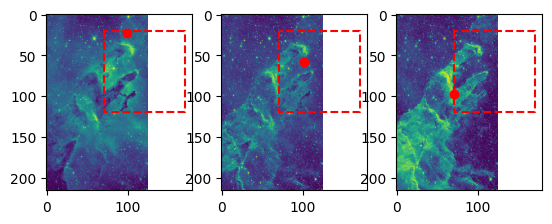

In [ ]:
path = ""
filename = "Pillars_of_Creation.png"

image = cv.imread(path + filename, cv.IMREAD_GRAYSCALE)
image = cv.resize(image,(0,0),fx=.25,fy=.25)
pillars = np.asarray(image)

print('Opened the image: %s'%filename)
print('Image size: %s'%str(np.shape(pillars)))

fig,ax = plt.subplots(1,3)
for i in range(3):
  ax[i].imshow(pillars[:,:,i])
  s = 50
  cenx,ceny = [120,70]
  ax[i].plot([cenx-s,cenx-s,cenx+s,cenx+s,cenx-s],[ceny-s,ceny+s,ceny+s,ceny-s,ceny-s],'--r')
  argy,argx = np.unravel_index(np.argmax(pillars[ceny-s:ceny+s,cenx-s:cenx+s,i]),
                               np.shape(pillars[ceny-s:ceny+s,cenx-s:cenx+s,i]))
  ax[i].plot(argx+cenx-s,argy+ceny-s,'or')

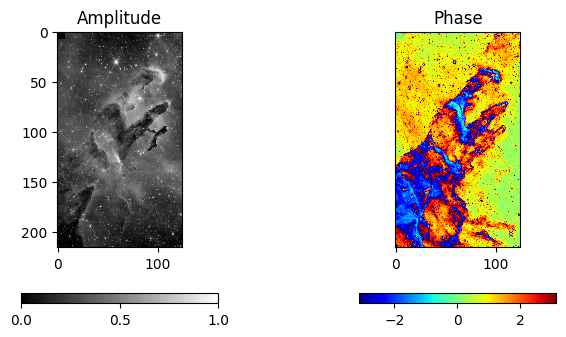

(216, 125)
(432, 250)
11548440.009078689
11548440.009078695


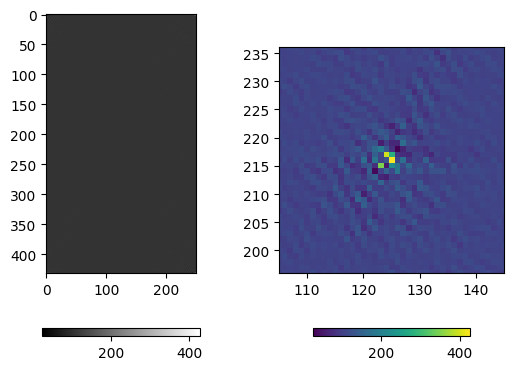

In [6]:
real_part = pillars[:, :, 0] / np.amax(np.abs(pillars[:, :, 0]))
imag_part = pillars[:, :, 2] / np.amax(np.abs(pillars[:, :, 2]))
complex_img = real_part* np.exp(1j * imag_part * np.pi * 2)
near_field = complex_img.copy()

#make a bright spot
near_field[0,0]= np.sum(near_field) + 1

plot_all(near_field,s=4)

y = np.abs(np.fft.fft2(near_field, s=np.array(np.shape(near_field))*2))**2
y = y / (np.shape(y)[0]*np.shape(y)[1])

fig,ax = plt.subplots(1,2)
ax0 = ax[0].imshow(y, cmap = 'gray');
ax1 = ax[1].imshow((np.fft.fftshift(y)))
ax[1].set_xlim([np.shape(y)[1]/2 - 20,np.shape(y)[1]/2 + 20])
ax[1].set_ylim([np.shape(y)[0]/2 - 20,np.shape(y)[0]/2 + 20])
fig.colorbar(ax1, ax=ax[1],  shrink=0.7, location='bottom')
fig.colorbar(ax0, ax=ax[0],  shrink=0.7,location='bottom')

print(np.shape(near_field))
print(np.shape(y))

print(np.sum(y))
print(np.sum(np.abs(near_field)**2))

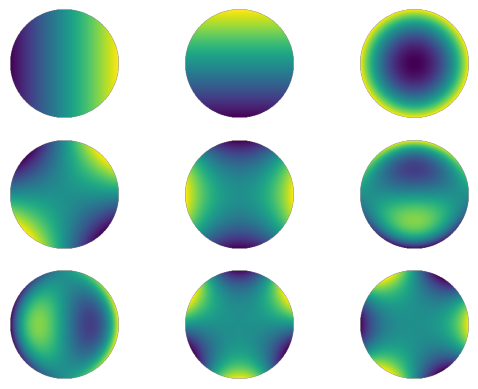

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from zernike import RZern

cart = RZern(6)
L, K = 200, 250
ddx = np.linspace(-1.0, 1.0, K)
ddy = np.linspace(-1.0, 1.0, L)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)

c = np.zeros(cart.nk)
plt.figure(1)
for i in range(1, 10):
    plt.subplot(3, 3, i)
    c *= 0.0
    c[i] = 1.0
    Phi = cart.eval_grid(c, matrix=True)
    plt.imshow(Phi, origin='lower', extent=(-1, 1, -1, 1))
    plt.axis('off')

plt.show()

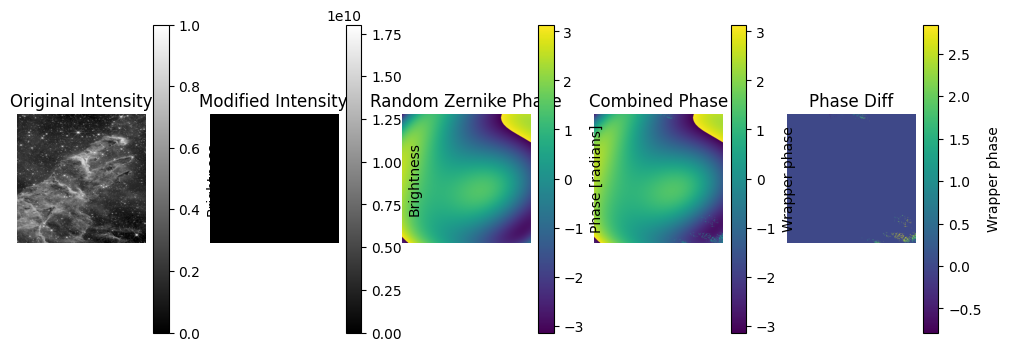

In [ ]:
from phastphase.data_generation import data_generation_utils

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

jax.config.update('jax_enable_x64', True)

# Generate unit disk mask
N = 512
y, x = jnp.linspace(-1, 1, N), jnp.linspace(-1, 1, N)
X, Y = jnp.meshgrid(x, y)
rho = jnp.sqrt(X**2 + Y**2)
theta = jnp.arctan2(Y, X)
mask = rho <= 1

# Load image as near field intensity
filename = "Pillars_of_Creation.png"
image = cv.imread(filename, cv.IMREAD_GRAYSCALE)
image = cv.resize(image,(N,N))
intensity = jnp.asarray(image)
intensity = intensity / jnp.max(intensity)

magnitude = jnp.sqrt(intensity)
intensity_orignal = intensity.astype(float).copy()

# plt.imshow(pillars, cmap='gray', origin='lower') 
# data_generation_utils.add_gaussian_spot(intensity)
magnitude = data_generation_utils.add_delta_spot(magnitude, x0=0, y0=0, radius = 1, amplitude_multiplier=1)

# Generate phase map
# phase_map = data_generation_utils.generate_zernike_phase_map((N,N), min_j=4, max_j=4, aperature="circular")
phase_map = data_generation_utils.generate_zernike_phase_map((N, N), aperature="cropped")
# phase_map += intensity_orignal
phase_map = phase_map.at[0,0].set(0)

# phase_map_np = np.asarray(phase_map)
# magnitude_np = np.asarray(magnitude)
# E_np = E = magnitude_np * np.exp(1j * phase_map_np) 

# Combine into complex field
# phase_map = phase_map.astype(jnp.float64)
# E = (magnitude.astype(jnp.float64) + 1e-12) * jnp.exp(1j * phase_map)

E = magnitude * jnp.exp(1j * phase_map) 
diff_map = jnp.angle(E) - phase_map
diff_mask = diff_map != 0

fig, ax = plt.subplots(1, 5, figsize=(12, 4))

im = ax[0].imshow(intensity_orignal, cmap='gray')
ax[0].set_title("Original Intensity")
fig.colorbar(im, label='Brightness', ax=ax[0])
ax[0].axis('off')

im = ax[1].imshow(magnitude ** 2, cmap='gray')
ax[1].set_title("Modified Intensity")
fig.colorbar(im, label='Brightness', ax=ax[1])
ax[1].axis('off')

im = ax[2].imshow(phase_map)
ax[2].set_title("Random Zernike Phase")
fig.colorbar(im, label='Phase [radians]', ax=ax[2])
ax[2].axis('off')

im = ax[3].imshow(jnp.angle(E))
ax[3].set_title("Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[3])
ax[3].axis('off')

im = ax[4].imshow(diff_map)
ax[4].set_title("Phase Diff")
fig.colorbar(im, label='Wrapper phase', ax=ax[4])
ax[4].axis('off')

plt.show()

Using winding numbers: (0, 0)
1.3981043733619707e-15
17197.904439397375
1.0000000000000007


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

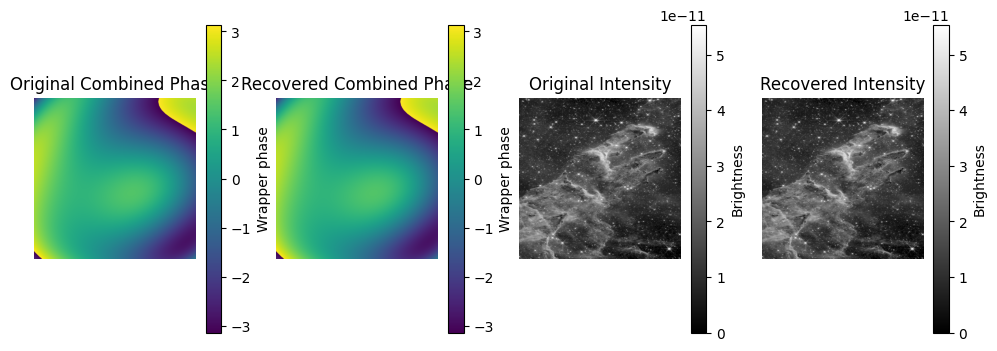

In [127]:
from phastphase.retrieval_jax import refine, retrieve
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)


near_field = jnp.copy(E)
y = jnp.abs(jnp.fft.fft2(near_field, s=jnp.array(jnp.shape(near_field))*2, norm="ortho"))**2
y = y / (jnp.shape(y)[0]*jnp.shape(y)[1])
# near_field = near_field / (jnp.shape(near_field)[0]*jnp.shape(near_field)[1])

# OPTIONAL: SHIFT
# y = jnp.fft.fftshift(y)

mask = jnp.ones_like(near_field)
x_out, val = retrieve(
    y,
    mask,
    max_iters=1000,
    descent_method=0,
    grad_tolerance=1e-14,
    wind_method = 0,
    winding_guess=(0, 0),
)

x_out = x_out / jnp.linalg.vector_norm(x_out)
near_field = near_field / jnp.linalg.vector_norm(near_field)
# diff_map = diff_map / jnp.linalg.vector_norm(diff_map)


print(jnp.linalg.vector_norm(x_out - near_field) / jnp.linalg.vector_norm(near_field))
print(jnp.sum(y))
print(jnp.sum(jnp.abs(near_field)**2))

fig, ax = plt.subplots(1, 4, figsize=(12, 4))

im = ax[0].imshow(jnp.angle(near_field) - diff_map)#, vmin=-jnp.pi/2, vmax=jnp.pi/2)
ax[0].set_title("Original Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[0])
ax[0].axis('off')

# x_out_angle = jnp.angle(x_out).at[diff_mask].set(diff_map)
# near_field_angle = jnp.angle(near_field).at[diff_mask].set(0)

x_out_angle = jnp.where(diff_map != 0, phase_map, jnp.angle(x_out))

# print((x_out_angle - near_field_angle) - diff_map)


# x_out_angle = jnp.where(jnp.angle(x_out) > (jnp.max(jnp.angle(x_out)) - 1e-5), 0, jnp.angle(x_out))
# x_out_angle = jnp.where(jnp.angle(x_out) < (jnp.min(jnp.angle(x_out)) + 1e-5), 0, x_out_angle)
# x_out_angle = jnp.where(jnp.angle(x_out) > (jnp.pi - 1e-5), 0, x_out_angle)
# x_out_angle = jnp.where(jnp.angle(x_out) < (-jnp.pi + 1e-5), 0, x_out_angle)

im = ax[1].imshow(x_out_angle)#, vmin=-jnp.pi/2, vmax=jnp.pi/2)
ax[1].set_title("Recovered Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[1])
ax[1].axis('off')

a = near_field.at[0, 0].set(0)
b = x_out.at[0, 0].set(0)

im = ax[2].imshow(jnp.abs(a)**2, cmap='gray')
ax[2].set_title("Original Intensity")
fig.colorbar(im, label='Brightness', ax=ax[2])
ax[2].axis('off')

im = ax[3].imshow(jnp.abs(b)**2, cmap='gray')
ax[3].set_title("Recovered Intensity")
fig.colorbar(im, label='Brightness', ax=ax[3])
ax[3].axis('off')


[305 348]
(228711.0765423517+0j)


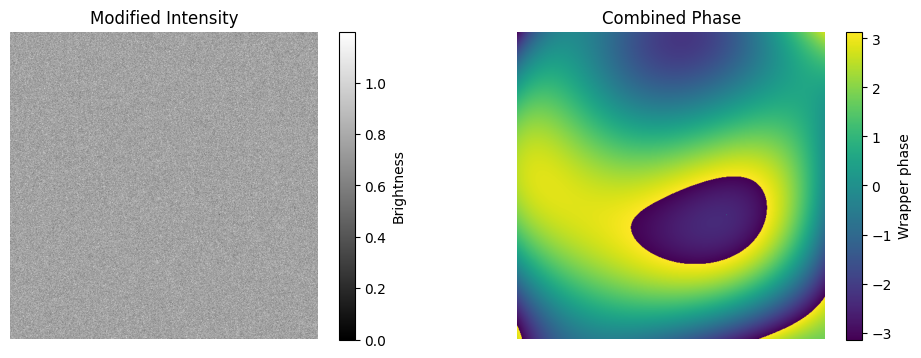

In [15]:
from phastphase.data_generation import data_generation_utils

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

jax.config.update('jax_enable_x64', True)

# Load image as near field intensity
filename = "datasets/dataset_generated_23_34_19_14_11_2025_512x512/case_3/2.npz"

data = np.load(filename)

near_field = data["near_field"]
bright_spot = data["spot_center"]
print(bright_spot)

print(near_field[int(bright_spot[0]), int(bright_spot[1])])
near_field[int(bright_spot[0]), int(bright_spot[1])] = 0.0

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(np.abs(near_field) ** 2, cmap='gray')
ax[0].set_title("Modified Intensity")
fig.colorbar(im, label='Brightness', ax=ax[0])
ax[0].axis('off')

im = ax[1].imshow(np.angle(near_field))
ax[1].set_title("Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[1])
ax[1].axis('off')

plt.show()

Using winding numbers: (3, 3)
8.343972e-07
0.99999964
0.9999997


(np.float64(-0.5), np.float64(63.5), np.float64(31.5), np.float64(-0.5))

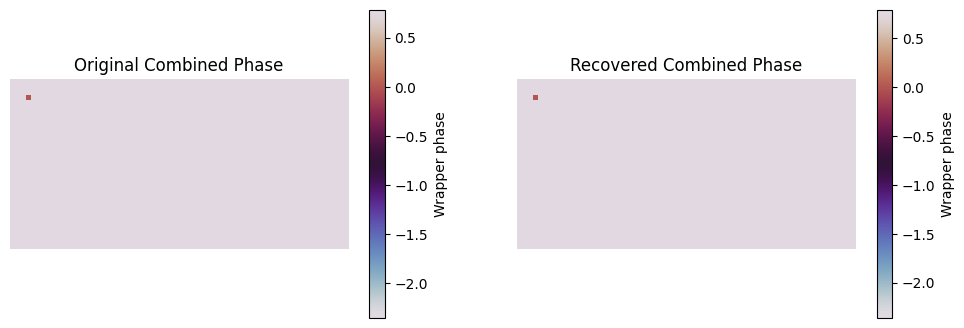

In [10]:
from jax import random
import jax.lax as lax
from phastphase.retrieval_jax import refine, retrieve
import jax.numpy as jnp

key = random.key(42)
key, subkey = random.split(key)

x_real = random.normal(key, shape=(32, 64))
x_complex = random.normal(key, shape=(32, 64))

x = jnp.copy(lax.complex(x_real, x_complex))
E = x.at[3, 3].set(10 * 64)

# im = plt.imshow(jnp.abs(x), cmap='gray')
# plt.show()

near_field = E.copy() / jnp.linalg.vector_norm(E)
y = np.abs(np.fft.fft2(near_field, s=np.array(np.shape(near_field))*2))**2
y = y / (np.shape(y)[0]*np.shape(y)[1])

# near_field = E.copy()/jnp.linalg.vector_norm(E)
# oversample = 2
# # near_field = near_field.at[0,0].set(1000*jnp.size(E))
# far_field_shape = (E.shape[0]*oversample, E.shape[1]*oversample)
# y = jnp.abs(jnp.fft.fft2(near_field, s=far_field_shape, norm="ortho"))**2

mask = jnp.ones_like(near_field)
x_out, val = retrieve(
    y,
    mask,
    max_iters=1000,
    descent_method=0,
    grad_tolerance=1e-14,
    wind_method = 0,
    # winding_guess=(0, 0),
)

print(jnp.linalg.vector_norm(x_out - near_field) / jnp.linalg.vector_norm(near_field))
print(np.sum(y))
print(np.sum(np.abs(near_field)**2))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(np.angle(near_field), cmap='twilight')
ax[0].set_title("Original Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[0])
ax[0].axis('off')

im = ax[1].imshow(np.angle(x_out), cmap='twilight')
ax[1].set_title("Recovered Combined Phase")
fig.colorbar(im, label='Wrapper phase', ax=ax[1])
ax[1].axis('off')

In [ ]:
import phastphase

def plot_all(reconstruction, s = 0):
    image = np.array(reconstruction.copy())
    if s>0:
        [i,j] = np.unravel_index(np.argmax(np.abs(image)),np.shape(image))
        if i<s:
            i=s
        if i>np.shape(image)[0]-s:
            i=np.shape(image)[0]-s
        if j<s:
            j=s
        if j>np.shape(image)[1]-s:
            j=np.shape(image)[1]-s
        image[i-s:i+s,j-s:j+s] = 0
    fig , ax = plt.subplots(1,2, figsize = (8,4))
    im0 = ax[0].imshow(np.abs(image), cmap="gray")
    #plt.colorbar(im0, ax=ax[1], fraction=0.046, pad=0.04)
    ax[0].set_title('Amplitude')
    im1 = ax[1].imshow(np.angle(image),cmap="jet", interpolation="none")
    ax[1].set_yticks([])
    #plt.colorbar(im1, ax=ax[2], fraction=0.046, pad=0.04)
    ax[1].set_title('Phase')
    fig.colorbar(im1, ax=ax[1],  shrink=0.7, location='bottom')
    fig.colorbar(im0, ax=ax[0],  shrink=0.7,location='bottom')
    plt.show()
    
#spectral initialization for a Schwartz object is all ones
guess_spectral = np.ones(np.shape(mask)) + 1j * 0
guess_spectral [0,0] = np.sum(guess_spectral)

recovery_writinger = phastphase.retrieval_jax.alternative_methods._gradient_flows.truncated_wirtinger_flow(
    guess_spectral,
    y,
    truncation_threshold=0.7,
    grad_tolerance=1e-3,
    iter_limit=1000,
)

plot_all(recovery_writinger[:np.shape(near_field)[0],:np.shape(near_field)[1]],s=1)


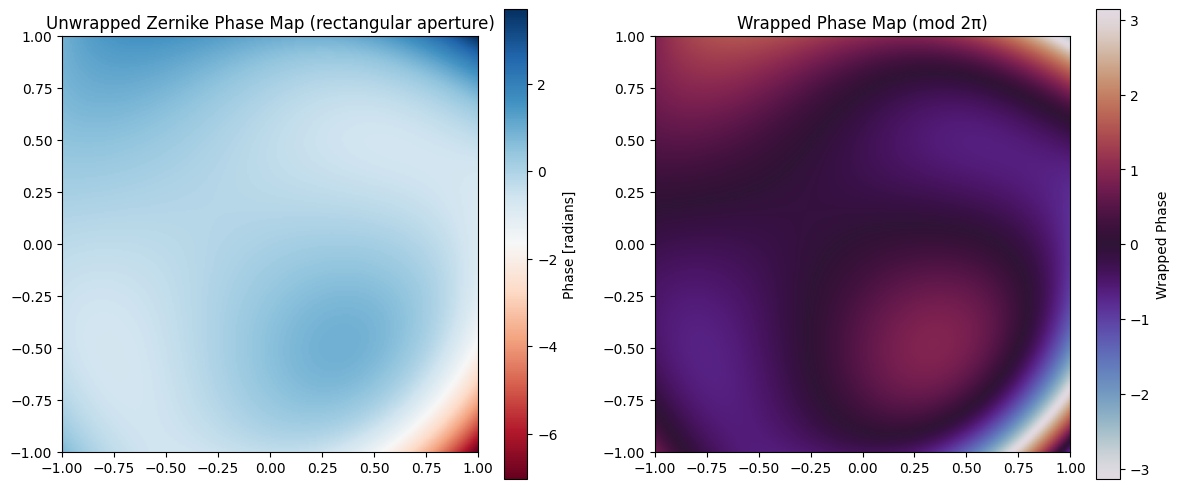

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

# ============================================================
# 1. Define Zernike polynomial (radial part)
# ============================================================
def R_nm(n, m, rho):
    """Radial part of Zernike polynomial"""
    R = np.zeros_like(rho)
    m = abs(m)
    for k in range((n - m)//2 + 1):
        c = ((-1)**k * factorial(n - k)) / (
            factorial(k) * factorial((n + m)//2 - k) * factorial((n - m)//2 - k)
        )
        R += c * rho**(n - 2*k)
    return R

# ============================================================
# 2. Define full Zernike mode
# ============================================================
def zernike(n, m, rho, theta):
    """Return Zernike mode Z_n^m on unit disk"""
    if m >= 0:
        return R_nm(n, m, rho) * np.cos(m * theta)
    else:
        return R_nm(n, -m, rho) * np.sin(-m * theta)

# ============================================================
# 3. Generate rectangular grid and map Zernikes
# ============================================================
N = 256
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

rho = np.sqrt(X**2 + Y**2)
theta = np.arctan2(Y, X)
mask = rho <= 1  # circular aperture

# ============================================================
# 4. Define physical aberrations (Zernike terms)
# ============================================================
# noll indices 2..14 correspond roughly to:
# tilt x, tilt y, defocus, astigmatism, coma, trefoil, spherical
zernike_terms = [
    (2, -2), (2, 0), (2, 2),   # astigmatism, defocus
    (3, -1), (3, 1),           # vertical/horizontal coma
    (4, 0), (4, 2), (4, -2)    # spherical, secondary astigmatism
]

rng = np.random.default_rng()
coeffs = rng.normal(scale=0.3, size=len(zernike_terms))  # random amplitudes (radians)

# ============================================================
# 5. Construct random realistic phase map
# ============================================================
phase = np.zeros_like(X)
for (nm, c) in zip(zernike_terms, coeffs):
    n, m = nm
    # Z = np.zeros_like(X)
    # Z[mask] = zernike(n, m, rho[mask], theta[mask])
    # phase += c * Z
    phase += c * zernike(n, m, rho, theta)


# Optional: wrap to [-π, π]
wrapped_phase = np.angle(np.exp(1j * phase))

# ============================================================
# 6. Plot results
# ============================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(phase, cmap='RdBu', origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar(label='Phase [radians]')
plt.title('Unwrapped Zernike Phase Map (rectangular aperture)')

plt.subplot(1, 2, 2)
plt.imshow(wrapped_phase, cmap='twilight', origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar(label='Wrapped Phase')
plt.title('Wrapped Phase Map (mod 2π)')

plt.tight_layout()
plt.show()
